# NMF, LSA, and LDA for Topic Modelling 

All routines from Scikit-Learn.  Data was cleaned and processed using Gensim.

### Prepare data

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import gensim
import time

from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from gensim.models.coherencemodel import CoherenceModel

import ipywidgets as widgets

In [2]:
# import NSF data
f = open('/project/biocomplexity/sdad/projects_data/ncses/prd/RND Topic Modelling/agency_data.sav', 'rb')

# import entire dataset
#f = open('/project/biocomplexity/sdad/projects_data/ncses/prd/RND Topic Modelling/lda_data.sav', 'rb')

[corpus, id2word, docs] = pickle.load(f)
f.close()

# corpus - word frequency in docs
# id2word - dictionary
# docs - lemmatized abstracts

In [3]:
# input needed here is one string per document (not a list of strings)

text = []
i=0
for doc in docs:
    text.append(" ".join(doc))

In [4]:
text[0:2]

['explore game base metaphor enhanced game design game method apply cognitive science metaphor theory design computer mediate learning environment process us structure map theory design videogame world align science concept rigorous specification procedure map relational structure target concept game world game design translate target concept game system game play game goal relational structure game world design analog target conceptual domain player begin construct mental model target concept interactive gameplay make learn concrete embody gameplay experience design guide learner relational structure target concept gameplay readiness activity prepare learner subsequent instruction primary objective cyber_enabled teach learn game base metaphor enhance learning object cygames empirically test application cognitive science theory aptly design videogame world provide common experience prepares educator learner achieve success cygames employ cognitive science informatic science analysis me

In [4]:
# run either first two lines or last two lines.  LDA - first two, NMF and LSA - last two

vectorizer = CountVectorizer(max_df=0.4, min_df=3, lowercase=False, max_features=int(len(docs)/2))
doc_term_matrix = vectorizer.fit_transform(text)

#==========================

#vectorizer = TfidfVectorizer(max_df=0.4, min_df=3, lowercase=False, max_features=int(len(docs)/2))
#tf_idf = vectorizer.fit_transform(text)

In [5]:
doc_term_matrix.shape

(116475, 58237)

### Exploration of document-term matrix

We view the transpose because it fits on the screen better!  So we view the Term-Document matrix.

In [6]:
@widgets.interact
def print_doc_term_mat(markersize=[0.01, 0.05, 0.1, 0.2, 0.3], precision=[0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 1]):
   
    print('Number of Documents:', tf_idf.shape[0])
    print('Number of Terms:', tf_idf.shape[1])
    
    plt.figure(figsize=(12,8))
    plt.spy(tf_idf.transpose(), markersize=markersize, precision=precision)  # precision=n: plots only those |elements| > n
    plt.title('Term-Document Matrix')
    plt.ylabel('Term')
    plt.xlabel('Document')
    plt.show

interactive(children=(Dropdown(description='markersize', options=(0.01, 0.05, 0.1, 0.2, 0.3), value=0.01), Dro…

### NMF

In [7]:
nmf_model = NMF(n_components=50, random_state=1)
W = nmf_model.fit_transform(tf_idf)
H = nmf_model.components_

### results

In [8]:
print(W.shape)
print(H.shape)
 

(116475, 50)
(50, 58237)


In [9]:
result = tf_idf - np.matmul(W,H)

In [10]:
np.linalg.norm(result, ord='fro')

122.75291241064336

In [6]:
# function slightly modified from https://nlpforhackers.io/topic-modeling/

def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):  # loop through each row of H.  idx = row index.  topic = actual row
        print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], topic[i])  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        for item in print_list:
            print(item)
        

In [12]:
print_topics(nmf_model, vectorizer, 20)


Topic 0:
('solar', 6.1482911344980495)
('wind', 3.11129743500115)
('sun', 0.738524743893545)
('plasma', 0.7017733591075304)
('corona', 0.6158177122935028)
('energy', 0.5961355097531869)
('flare', 0.5662192321765079)
('magnetic_field', 0.5428221268333046)
('magnetosphere', 0.47465049764984785)
('magnetic', 0.4742786494747)
('ion', 0.4458241665689123)
('coronal', 0.4003035810423043)
('acceleration', 0.3752361645551772)
('interaction', 0.33571332146819377)
('atmosphere', 0.3309983022395189)
('heat', 0.32714956592060757)
('event', 0.32520282034370157)
('region', 0.307083262714378)
('electron', 0.2859168239436193)
('outer', 0.2839252644394495)

Topic 1:
('nasa', 1.86761188498132)
('program', 1.2692271649154834)
('support', 0.8725333784717236)
('student', 0.32806862017058364)
('university', 0.30845719114849873)
('education', 0.2674477902493238)
('year', 0.261347466303645)
('request', 0.22521089486160986)
('continue', 0.2231618920585859)
('state', 0.21351334171532704)
('stem', 0.199958909800

In [12]:
#top_n = 10 # print out top_n words from each topic

@widgets.interact
def print_one_topic(topic=range(0,len(H)), top_n=[5,10,15,20,25,30]):
    
    print("\nTopic %d:" % (topic))
    print_list = [(vectorizer.get_feature_names()[i], H[topic][i])  
                        for i in H[topic].argsort()[:-top_n - 1:-1]]
    for item in print_list:
        print(item)
    

interactive(children=(Dropdown(description='topic', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

### LSA (Latent Semantic Analysis)

In [13]:
lsa_model = TruncatedSVD(n_components=50, random_state=1)
USigma = lsa_model.fit_transform(tf_idf)
Vtrans = lsa_model.components_

#### Results

In [14]:
lsa_model.explained_variance_ratio_.sum()

0.09603690493157374

In [15]:
lsa_model.singular_values_

array([14.60730167,  8.93745612,  7.87219144,  7.69085421,  7.03677958,
        6.73121805,  6.57112056,  6.5124716 ,  6.41640352,  6.15082164,
        6.01827382,  5.93750075,  5.86467763,  5.75219828,  5.65804864,
        5.62117406,  5.59344161,  5.53434854,  5.44927409,  5.40158766,
        5.352697  ,  5.26003204,  5.25261575,  5.23150628,  5.19578259,
        5.16441309,  5.11340221,  5.05018914,  5.01080112,  5.00419452,
        4.97768966,  4.92565395,  4.90485578,  4.8761555 ,  4.8465901 ,
        4.83077286,  4.7786998 ,  4.74415253,  4.70585955,  4.69427349,
        4.65874526,  4.62389682,  4.61464959,  4.57418897,  4.54185907,
        4.50688364,  4.48613747,  4.4793933 ,  4.41781551,  4.40043421])

In [16]:
print(USigma.shape)
print(Vtrans.shape)

(16006, 50)
(50, 10312)


In [17]:
result = tf_idf - np.matmul(USigma,Vtrans)
np.linalg.norm(result, ord='fro')

119.59752696469741

In [18]:
print_topics(lsa_model, vectorizer, 20)


Topic 0:
('propose', 0.20741098960914542)
('data', 0.20258550776008197)
('nasa', 0.18572312857629186)
('research', 0.17215713071179614)
('system', 0.1721522720079735)
('use', 0.16959140436412537)
('model', 0.15570343191267283)
('space', 0.14604742275988156)
('solar', 0.1457353003019626)
('science', 0.13780159091869099)
('mission', 0.1328501151157259)
('observation', 0.12399077068608956)
('earth', 0.12000345066464381)
('high', 0.11376101843239005)
('program', 0.11362134727800766)
('support', 0.10542629307165037)
('develop', 0.1034469195644516)
('surface', 0.1031614750802511)
('provide', 0.09968637230150565)
('satellite', 0.09735556234582542)

Topic 1:
('nasa', 0.3618694631188823)
('space', 0.26116854264067074)
('research', 0.25943508214312955)
('science', 0.25856007745126086)
('program', 0.20092659464076718)
('support', 0.175656865232316)
('center', 0.1633525345453509)
('technology', 0.1288813410332826)
('university', 0.11975287815743757)
('mission', 0.10802325308834831)
('education', 

In [19]:
#top_n = 10 # print out top_n words from each topic

@widgets.interact
def print_one_topic(topic=range(0,len(Vtrans)), top_n=[5,10,15,20,25,30]):
    
    print("\nTopic %d:" % (topic))
    print_list = [(vectorizer.get_feature_names()[i], Vtrans[topic][i])  
                        for i in Vtrans[topic].argsort()[:-top_n - 1:-1]]
    for item in print_list:
        print(item)

interactive(children=(Dropdown(description='topic', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

## LDA from Scikit-Learn

In [14]:
num_topics = 30
t1 = time.time()
lda_model = LatentDirichletAllocation(n_components=num_topics, doc_topic_prior = 1/num_topics, 
                                      topic_word_prior=0.1, n_jobs=39) #learning_method='online')
DT = lda_model.fit_transform(doc_term_matrix)
t2 = time.time()
print('Time = ', t2-t1, 'seconds' )

TT = lda_model.components_

Time =  371.64752221107483 seconds


In [21]:
# most likely skip this!

result = tf_idf - np.matmul(DT,TT)
np.linalg.norm(result, ord='fro')

42154.916019766046

In [13]:
print_topics(lda_model, vectorizer, 20)


Topic 0:
('university', 49.93864396278569)
('vesta', 38.05021381625102)
('arizona', 25.453718226356244)
('develop', 24.73292867929884)
('system', 24.63606000464106)
('laboratory', 24.343689079831236)
('propose', 22.878514469226086)
('extreme', 22.465641264356943)
('participate', 22.30579211049962)
('phase', 22.057459587155897)
('investigation', 22.009521001535518)
('material', 20.137516710944595)
('dawn', 19.9126345796277)
('mineral', 19.85066372664069)
('sulfate', 19.832630723353795)
('lightning', 18.45437758515225)
('large', 18.209228038940857)
('american', 17.206124181161865)
('service', 17.20019188860539)
('network', 17.000131536670416)

Topic 1:
('magnetic', 307.81969458867974)
('field', 275.2334386376033)
('energy', 92.38379231354139)
('high', 88.81929725666228)
('magnetosphere', 86.8592922324501)
('observation', 58.991404544527065)
('line', 57.131831048172266)
('time', 55.23262677183506)
('structure', 49.97277413150809)
('strong', 49.830847970700276)
('pulsar', 46.5358643888866

In [24]:
#top_n = 10 # print out top_n words from each topic

@widgets.interact
def print_one_topic(topic=range(0,len(TT)), top_n=[5,10,15,20,25,30]):
    
    print("\nTopic %d:" % (topic))
    print_list = [(vectorizer.get_feature_names()[i], TT[topic][i])  
                        for i in TT[topic].argsort()[:-top_n - 1:-1]]
    for item in print_list:
        print(item)

interactive(children=(Dropdown(description='topic', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=0), Dropdown…

In [21]:
# approximate perplexity - SKIP

lda_model.perplexity(doc_term_matrix)

1787.9585147383964

In [12]:
# this attribute is perplexity

lda_model.bound_

3029.560515369683

In [13]:
# approximate log-likelihood - SKIP

lda_model.score(doc_term_matrix)

-816229524.9421033

### Tune number of topics by minimizing perplexity 

In [6]:
# function copied from https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
# minor alterations made

def compute_perplexity_values(doc_term_matrix, n_topics):
    """
    Compute perplexity for various number of topics

    Parameters:
    ----------
    doc_term_matrix
    n_topics : list of number of topics

    Returns:
    -------
    perplexity_values : Perplexity values corresponding to the LDA model with respective number of topics
    """
    perplexity_values = []
    
    for num_topics in n_topics:
        lda_model = LatentDirichletAllocation(n_components=num_topics, doc_topic_prior = 1/num_topics, 
                                              topic_word_prior=0.1, n_jobs=39)
        DT = lda_model.fit_transform(doc_term_matrix)
        perplexity_values.append(lda_model.bound_)
        print('Number of topics =', num_topics, "complete.")

    return perplexity_values

In [7]:
# plot results 

# code copied from https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
# minor alterations made

n_topics = [4,8,12,16,20,24]
pv1 = compute_perplexity_values(doc_term_matrix=doc_term_matrix, n_topics=n_topics)
n_topics = [28,32,36,40,44,48]
pv2 = compute_perplexity_values(doc_term_matrix=doc_term_matrix, n_topics=n_topics)
n_topics = [52,56,60,75,100,125]
pv3 = compute_perplexity_values(doc_term_matrix=doc_term_matrix, n_topics=n_topics)


Number of topics = 4 complete.
Number of topics = 8 complete.
Number of topics = 12 complete.
Number of topics = 16 complete.
Number of topics = 20 complete.
Number of topics = 24 complete.
Number of topics = 28 complete.
Number of topics = 32 complete.
Number of topics = 36 complete.
Number of topics = 40 complete.
Number of topics = 44 complete.
Number of topics = 48 complete.
Number of topics = 52 complete.
Number of topics = 56 complete.
Number of topics = 60 complete.
Number of topics = 75 complete.
Number of topics = 100 complete.
Number of topics = 125 complete.


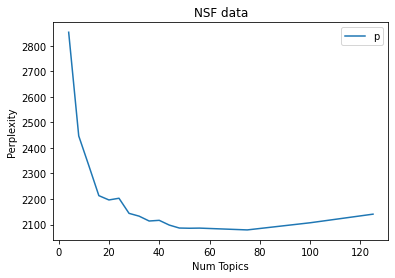

In [8]:
perplexity_values = pv1 + pv2 + pv3
n_topics = [4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,75,100,125] 

# Show graph
#plt.figure(figsize=(7,7))
plt.plot(n_topics, perplexity_values)
plt.title("NSF data")
plt.xlabel("Num Topics")
plt.ylabel("Perplexity")
plt.legend(("perplexity"), loc='best')

plt.show()

In [9]:
pickle.dump(perplexity_values, open('pv_nsf.sav','wb'))

### Tune number of topics by maximizing coherence and minimizing perplexity

In [7]:
# Function to format topics as a "list of list of strings".
# Needed for topic coherence function in Gensim

# function slightly modified from https://nlpforhackers.io/topic-modeling/

def list_topics(model, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(model.components_):  # loop through each row of H.  idx = row index.  topic = actual row
        #print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
        
    return topic_words

In [11]:
# function adapted from https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/

def compute_eval_values(doc_term_matrix, n_topics, vectorizer, corpus, id2word, docs):
    """
    Compute perplexity and c_v topic coherence for various number of topics

    Parameters:
    ----------
    doc_term_matrix
    n_topics : list of number of topics

    Returns:
    -------
    coherence_values : c_v topic coherence values corresponding to the LDA model with respective number of topics
    """
    
    perplexity_values = []
    coherence_values = []
    
    i = 0
    for num_topics in n_topics:
        
        # create model
        lda_model = LatentDirichletAllocation(n_components=num_topics, doc_topic_prior = 1/num_topics, 
                                              topic_word_prior=0.1, n_jobs=39, random_state=i)
        lda_model.fit_transform(doc_term_matrix)
        
        # compute perplexity
        perplexity_values.append(lda_model.bound_)
        
        # create list of topics
        topics = list_topics(lda_model, vectorizer, top_n=10)
        
        # calculate coherence
        cm = CoherenceModel(topics=topics, corpus=corpus, dictionary=id2word, texts=docs, 
                            coherence='c_v', processes=20) #window_size=500 ) 
        coherence_values.append(cm.get_coherence())
        
        # output completion message
        i = i+1
        print('Number of topics =', num_topics, "complete.")

    return perplexity_values, coherence_values

In [12]:
# plot results 

# code copied from https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
# minor alterations made

n_topics = [4,8,12,16,20,24]
[pv1, cv1] = compute_eval_values(doc_term_matrix=doc_term_matrix, n_topics=n_topics, vectorizer=vectorizer, 
                               corpus=corpus, id2word=id2word, docs=docs)
n_topics = [28,32,36,40,44,48]
[pv2, cv2] = compute_eval_values(doc_term_matrix=doc_term_matrix, n_topics=n_topics, vectorizer=vectorizer, 
                               corpus=corpus, id2word=id2word, docs=docs)
n_topics = [52,56,60,75,100,125]
[pv3, cv3] = compute_eval_values(doc_term_matrix=doc_term_matrix, n_topics=n_topics, vectorizer=vectorizer, 
                               corpus=corpus, id2word=id2word, docs=docs)

Number of topics = 4 complete.
Number of topics = 8 complete.
Number of topics = 12 complete.
Number of topics = 16 complete.
Number of topics = 20 complete.
Number of topics = 24 complete.
Number of topics = 28 complete.
Number of topics = 32 complete.
Number of topics = 36 complete.
Number of topics = 40 complete.
Number of topics = 44 complete.
Number of topics = 48 complete.
Number of topics = 52 complete.
Number of topics = 56 complete.
Number of topics = 60 complete.
Number of topics = 75 complete.
Number of topics = 100 complete.
Number of topics = 125 complete.


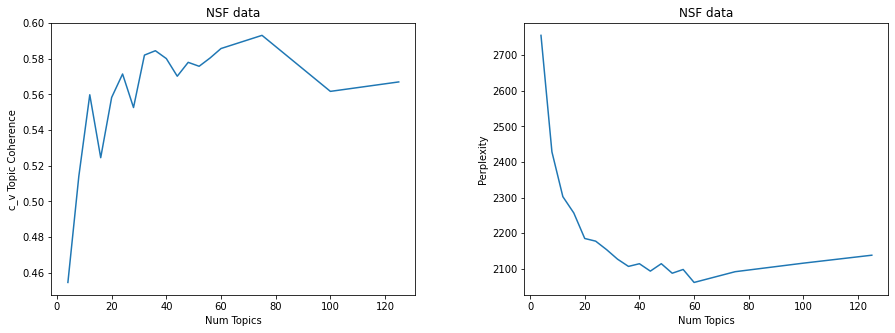

In [14]:
perplexity_values = pv1 + pv2 + pv3
coherence_values = cv1 + cv2 + cv3
n_topics = [4,8,12,16,20,24,28,32,36,40,44,48,52,56,60,75,100,125] 

# Show graph
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(n_topics, coherence_values)
plt.title("NSF data")
plt.xlabel("Num Topics")
plt.ylabel("c_v Topic Coherence")
#plt.legend(("coherence"), loc='best')

plt.subplot(1,2,2)
plt.plot(n_topics, perplexity_values)
plt.title("NSF data")
plt.xlabel("Num Topics")
plt.ylabel("Perplexity")
#plt.legend(("perplexity"), loc='best')

plt.subplots_adjust(wspace=0.3)
#plt.tight_layout()
plt.show()

In [15]:
pickle.dump([perplexity_values, coherence_values], open('eval_nsf.sav','wb'))

# Multiple Runs of same model to compare topics

In [8]:
# function copied from https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
# minor alterations made

def model_runs(doc_term_matrix, num_runs, num_topics):
    """
    Create and save n models

    Parameters:
    ----------
    doc_term_matrix 
    num_runs : number of models to create
    num_topics: number of topics to use in each model

    Returns:
    -------
    model_list : List of LDA topic models
    """

    model_list = []
    
    for i in range(num_runs):
        
        lda_model = LatentDirichletAllocation(n_components=num_topics, doc_topic_prior = 1/num_topics, 
                                              topic_word_prior=0.1, n_jobs=39, random_state=i)
        lda_model.fit_transform(doc_term_matrix)
        model_list.append(lda_model)
      
        print('Iteration', i, "complete.")

    return model_list 

In [9]:
models = model_runs(doc_term_matrix, num_runs=3, num_topics=3)

Iteration 0 complete.
Iteration 1 complete.
Iteration 2 complete.


In [10]:
models

[LatentDirichletAllocation(batch_size=128, doc_topic_prior=0.3333333333333333,
                           evaluate_every=-1, learning_decay=0.7,
                           learning_method='batch', learning_offset=10.0,
                           max_doc_update_iter=100, max_iter=10,
                           mean_change_tol=0.001, n_components=3, n_jobs=39,
                           perp_tol=0.1, random_state=None, topic_word_prior=0.1,
                           total_samples=1000000.0, verbose=0),
 LatentDirichletAllocation(batch_size=128, doc_topic_prior=0.3333333333333333,
                           evaluate_every=-1, learning_decay=0.7,
                           learning_method='batch', learning_offset=10.0,
                           max_doc_update_iter=100, max_iter=10,
                           mean_change_tol=0.001, n_components=3, n_jobs=39,
                           perp_tol=0.1, random_state=None, topic_word_prior=0.1,
                           total_samples=1000000.0

In [16]:
models[0].topic_word_prior_

0.1

In [30]:
import pyLDAvis.sklearn
 
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, tf_idf, vectorizer, mds='pcoa')
panel

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.116091 -0.011623       1        1  22.588372
7     -0.141663  0.127213       2        1  19.065994
0     -0.025908 -0.207511       3        1  13.649465
8     -0.083858  0.039314       4        1  11.397670
2     -0.034914 -0.077439       5        1   9.008539
4     -0.040455  0.033708       6        1   7.764595
9      0.063658 -0.040941       7        1   5.635778
5      0.049676  0.065760       8        1   4.761336
1      0.143853  0.016464       9        1   3.274612
6      0.185701  0.055056      10        1   2.853640, topic_info=                           Term        Freq       Total Category  logprob  \
8799                       star   89.000000   89.000000  Default  30.0000   
3541                     galaxy   91.000000   91.000000  Default  29.0000   
7190              precipitation   59.000000   59.000000  Default  28.0000   
5980                       nasa  235.000000  235.000000  Default  27.0000   
5374                        mar  109.000000  109.000000  Default  26.0000   
...                         ...         ...         ...      ...      ...   
9787  university_california_los    3.245175    8.663747  Topic10  -6.3649   
416                     angeles    3.245175    8.663747  Topic10  -6.3649   
4103                       http    2.770558    4.931850  Topic10  -6.5231   
6767                    partial    2.784074    8.841720  Topic10  -6.5182   
2279                     design    2.849955   87.886874  Topic10  -6.4948   

      loglift  
8799  30.0000  
3541  29.0000  
7190  28.0000  
5980  27.0000  
5374  26.0000  
...       ...  
9787   2.5746  
416    2.5746  
4103   2.9799  
6767   2.4010  
2279   0.1278  

[713 rows x 6 columns], token_table=       Topic      Freq                    Term
term                                          
54         8  0.665341                accident
67         2  0.955605                 accrete
69         2  0.917746               accretion
69         6  0.033991               accretion
112        5  0.830961          active_passive
...      ...       ...                     ...
10286      6  0.054894                    year
10286      7  0.036596                    year
10286      8  0.009149                    year
10286      9  0.009149                    year
10287      7  0.936978  year_incremental_years

[1744 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 8, 1, 9, 3, 5, 10, 6, 2, 7])

# Output results to CSV

In [14]:
n_words=30
n_topics=50

In [10]:
def topics_to_dataframe(model, vectorizer, top_n=10):
    all_topics=[]
    for idx, topic in enumerate(model.components_):  # loop through each row of H.  idx = row index.  topic = actual row
        #print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
        print_list = [(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]]
        all_topics.append(print_list)
    return all_topics

In [ ]:
#Compare your outputs for 10 runs

model_df_list=[]
for idx in range(10):
    output=topics_to_dataframe(models[idx],vectorizer,top_n=n_words)
    model_df=pd.DataFrame(output,index=[['Topic'+str(x) for x in range(n_topics)]])
    model_df=model_df.T.set_index(pd.MultiIndex.from_tuples([('Model '+str(idx),'Word '+str(x)) for x in range(n_words)]))
    model_df_list.append(model_df)
master_df=pd.concat(model_df_list)

# CHANGE THIS LINE
#master_df.to_csv('Term-Topic Ouputs for NSF Dataset - NMF Model - 50 Topics.csv')

In [15]:
#Chosen Model Output
output=topics_to_dataframe(lsa_model,vectorizer,top_n=n_words)
model_df=pd.DataFrame(output,index=[['Topic'+str(x) for x in range(n_topics)]])
model_df=model_df.T.set_index(pd.MultiIndex.from_tuples([('Model '+str(0),'Word '+str(x)) for x in range(n_words)]))

# CHANGE THIS LINE
#model_df.to_csv('OutputOfChosenNSFData_LSA_50Model.csv')

In [ ]:
output=chosen_model.transform(tf_idf)
doc_topic_matrix=pd.DataFrame(output,columns=['Topic_'+str(x) for x in range(n_topics)])
admin=pd.read_csv('/project/biocomplexity/sdad/projects_data/ncses/prd/RND Topic Modelling/FRAbstractsProcessed.csv')
nsf_admin=admin.loc[admin['AGENCY']=='NSF']

#Make sure your rows are identical
(nsf_admin['lemma_abstracts'].reset_index()['lemma_abstracts']==docs).value_counts()

# CHANGE FILE NAME in this line
pd.concat([admin[['PROJECT_ID', 'ABSTRACT', 'FY',
        'DEPARTMENT', 'AGENCY', 'IC_CENTER',
       'PROJECT_NUMBER', 'PROJECT_TITLE', 'PROJECT_TERMS',
       'CONTACT_PI_PROJECT_LEADER', 'OTHER_PIS', 'ORGANIZATION_NAME',
       'CFDA_CODE', 'FY_TOTAL_COST', 'working_abstract',
       'tokened_abstracts', 'tokened_docs_nostop', 'tns_bi_tri_docs',
       'lemma_abstracts']].reset_index(),doc_topic_matrix],axis=1).to_csv(#'NSFData_NMF_TopicDataFrame.csv')